<a href="https://colab.research.google.com/github/ZahraDehghani99/Natural-Language-Processing/blob/main/HW5/text_classification_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Work5 - Document Categorization using Transformers

In [1]:
!pip install -q python-bidi arabic-reshaper

In [2]:
!pip install -q transformers datasets

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

# for diplay persian texts in the right way
from bidi.algorithm import get_display
from arabic_reshaper import reshape

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read data and Data preprocessing

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/NLP/HW4/persica_final_edit.csv')
# df.columns = ['text', 'label']
# df.to_csv('/content/drive/MyDrive/NLP/HW5/persica_hw5.csv', index=False)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/HW5/persica_hw5.csv')

In [5]:
df.head()

,text,label
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي


In [ ]:
print(f'df shape : {df.shape}')

df shape : (10988, 2)


In [ ]:
df.label.value_counts()

آموزشي        1000
اقتصادي       1000
بهداشتي       1000
مذهبي         1000
اجتماعي        999
فرهنگي         999
ورزشي          999
تاريخي         998
سياسي          998
فقه و حقوق     998
علمي           997
Name: label, dtype: int64

Let's see the data distribution in each class.

In [ ]:
classes = [get_display(reshape(label)) for label in df.label]
y_fa = pd.DataFrame(classes)
y_fa.columns = ['label']

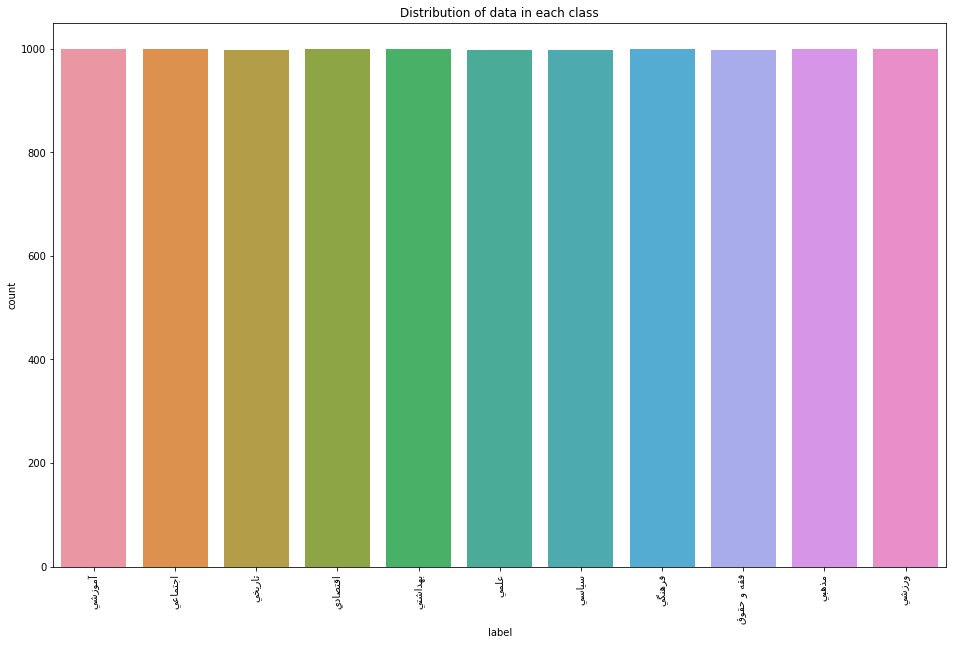

In [ ]:
fig = plt.figure(figsize=(16,10))
sns.countplot(x="label", data=y_fa)
plt.title("Distribution of data in each class")
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=15)
plt.show()

Let's see length of the news in each class.

In [7]:
df["Word per New"] = df["text"].str.split().apply(len)

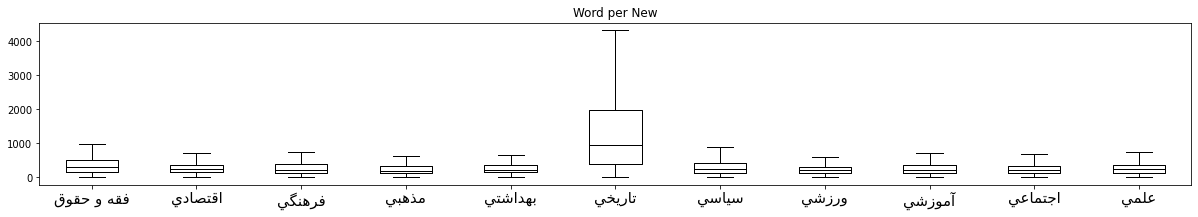

In [ ]:
df.boxplot("Word per New", by=y_fa["label"] , grid=False, showfliers=False,
           color="black")

plt.rcParams["figure.figsize"] = (20,3)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
df.head()

,text,label,Word per New
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,365
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,106
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,114
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,351
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي,215


In [ ]:
max(df["Word per New"])

6332

### Split X and y

In [8]:
X = df.drop(columns=['Word per New', 'label'])
y = pd.DataFrame(df['label'])

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X shape : (10988, 1)
y shape : (10988, 1)


In [ ]:
X.head()

,text
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...


### Train test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (8790, 1)
X_test shape: (2198, 1)
y_train shape: (8790, 1)
y_test shape: (2198, 1)


### Label Encoder

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

array([8, 5, 3, ..., 4, 8, 1])

In [ ]:
inv =  le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
classes = []
for i in range(len(inv)):
  classes.append(inv[i])
  print(f'{inv[i]} => {i}')

آموزشي => 0
اجتماعي => 1
اقتصادي => 2
بهداشتي => 3
تاريخي => 4
سياسي => 5
علمي => 6
فرهنگي => 7
فقه و حقوق => 8
مذهبي => 9
ورزشي => 10


### Append y to x for train set and test set

In [11]:
X_train['label'] = y_train.tolist()
X_test['label'] = y_test.tolist()

In [13]:
# X_train.to_csv('/content/drive/MyDrive/HW5/data/train.csv', index=False)
# X_test.to_csv('/content/drive/MyDrive/HW5/data/test.csv', index=False)

In [14]:
train = pd.read_csv('/content/drive/MyDrive/HW5/data/train.csv')
train.head()

,text,label
0,به گزارش خبرگزاري دانشجويان ايران (ايسنا) به ن...,5
1,رييس مركز مديريت بيماريهاي وزارت بهداشت از اجر...,3
2,به گزارش خبرنگار سياسي خبرگزاري دانشجويان ايرا...,5
3,به گزارش ايسنا، پويان شاهرخي مدير عامل خانه سي...,7
4,معاون سازمان سنجش آموزش كشور گفت: آزمون مرحله ...,0


In [15]:
print(f'train shape : {train.shape}')

train shape : (8790, 2)


In [17]:
test = pd.read_csv('/content/drive/MyDrive/HW5/data/test.csv')
test.head()

,text,label
0,به گزارش خبرنگار سرويس ارتباطات خبرگزاري دانشج...,6
1,به گزارش ايسنا،در اين مراسم كه به رياست آقامحم...,10
2,به گزارش گروه دريافت ايسنا، حميد توكلي طاهباز،...,2
3,به گزارش خبرنگار خبرگزاري دانشجويان ايران (ايس...,7
4,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، تيم...,10


In [18]:
print(f'test shape : {test.shape}')

test shape : (2198, 2)


## Load dataset using datasets

In [5]:
from datasets import load_dataset

PATH = "/content/drive/MyDrive/HW5/data/"
dataset = load_dataset("csv", data_files={"train": PATH + "train.csv", "test": PATH + "test.csv"})

Using custom data configuration default-d65cd567ec7ac95d


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d65cd567ec7ac95d/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8790
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2198
    })
})

In [23]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 8790
})

In [24]:
dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

In [25]:
dataset['train'][0]

{'label': 5,
 'text': 'به گزارش خبرگزاري دانشجويان ايران (ايسنا) به نقل از خبرگزاري آسوشيتدپرس، تام ديلي، نماينده\u200cي جمهوري خواه تگزاس در مجلس نمايندگان پس از كناره\u200cگيري در نامه\u200cاي به همكاران جمهوريخواه خود نوشت: در طول دوران حضور من در كنگره هميشه در مسري اخلاق مدارانه حركت كرده\u200cام و قوانين سرزمين\u200cمان را مدنظر داشته\u200cام. وي كه در حال حاضر در تگزاس با دعوي\u200cاي عليه خود به خاطر تقلب انتخاباتي مواجه شده است، همواره تاكيد كرده كه پس از اثبات بي\u200cگناهي\u200cاش وظايف خود را مجددا از سر مي\u200cگيرد. رقابت بر سر جانشيني وي به عنوان رهبر اكثريت جمهوري خواه در مجلس نمايندگان شدت گرفته است. روي بلو نت، از ايالت ميسوري و جان بونر، از اوهايو مهم\u200cترين رقيبان براي تصدي اين پست مي\u200cباشند. از سوي ديگر دموكرات\u200cهاي كنگره در تلاش هستند كه در انتخابات ميان دوره\u200cيي مجلس كه در نوامبر 2006 برگزار خواهد شد، رياست مجلس را به دست آورند. نانسي پلوسي، از كاليفرنيا و رهبر دموكرات\u200cهاي مجلس در رابطه با رسوايي پيش آمده گفت: فرهنگ فساد و ارتشا در جناح جمهوري

## Define needed functions

### Defining the performance metrics

In [25]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids 
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Defining Confusion matrix

In [26]:
classes = ["آموزشي", "اجتماعي", "اقتصادي", "بهداشتي", "تاريخي", "سياسي", "علمي", "فرهنگي", "فقه و حقوق", "مذهبي", "ورزشي"]
classes_fa_style = [get_display(reshape(i)) for i in classes]

In [27]:
def confusion_matrix(y_test, y_pred):
  labels = [i for i in range(len(list(set(y_test))))]
  df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels,
                columns = labels)
  plt.figure(figsize=(16,10))
  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  class_names= classes
  # set persian names in correct way
  class_names = [get_display(reshape(label)) for label in class_names]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()
  plt.show()

### Defining the label2int

In [28]:
def inverse(idx):
  inv = {0: "آموزشي",
         1: "اجتماعي",
         2: "اقتصادي",
         3: "بهداشتي",
         4: "تاريخي",
         5: "سياسي",
         6: "علمي",
         7: "فرهنگي",
         8: "فقه و حقوق",
         9: "مذهبي",
         10: "ورزشي"}
  return inv[idx]         

### Defining Forward parss loss

In [29]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                        reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
  "predicted_label": pred_label.cpu().numpy()}

## Text Classification using ParsBERT v1.0 Model

### Tokenizing the whole dataset

In [6]:
from transformers import AutoTokenizer

model_ckpt = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [7]:
tokenizer

PreTrainedTokenizerFast(name_or_path='HooshvareLab/bert-base-parsbert-uncased', vocab_size=100000, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [28]:
tokenizer.vocab_size

100000

In [29]:
tokenizer.model_max_length

1000000000000000019884624838656

In [30]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

اینجا رو تغییر دادم. در سایز ورودی فکر کنم مشکل داره.

In [8]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [9]:
print(tokenize(dataset["train"][0]))

{'input_ids': [2, 2031, 2248, 61826, 1216, 5360, 42906, 7764, 2616, 9, 7764, 39929, 10, 2031, 2836, 2036, 61826, 1216, 13697, 3806, 1160, 5458, 300, 9937, 47982, 1173, 1216, 300, 9010, 10308, 2062, 1216, 3277, 1216, 2683, 12673, 2028, 2543, 9010, 10308, 1160, 2276, 2297, 2036, 1, 2028, 22560, 1216, 2031, 1, 3277, 1216, 5596, 2081, 3695, 17, 2028, 2962, 3595, 2492, 2078, 2028, 1, 2063, 1216, 2749, 2028, 63781, 1216, 5976, 49909, 1, 1, 331, 3986, 10308, 5292, 30344, 2079, 2049, 7427, 17027, 15, 331, 1216, 1, 2028, 2290, 2863, 2028, 12673, 2037, 31533, 24277, 1216, 2395, 7880, 2081, 2031, 2855, 11040, 2829, 1216, 3440, 2110, 2045, 300, 4289, 1, 1, 1, 2297, 2036, 7151, 58465, 81593, 1177, 24277, 1176, 39810, 2081, 2049, 6944, 2036, 2140, 328, 1216, 1161, 25401, 1160, 15, 3396, 2043, 2140, 21782, 10308, 1216, 331, 1216, 2031, 2339, 4153, 1, 3277, 1216, 2683, 2028, 2543, 9010, 10308, 1160, 2276, 4306, 2563, 2045, 15, 38808, 5418, 3767, 300, 2036, 7764, 3064, 328, 52871, 2034, 1216, 331, 3059

In [10]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tunning Transformers

In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda')

In [13]:
!nvidia-smi

Thu Aug  4 18:26:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You will see a warning that some parts of the model are randomly initialized.
This is normal since the classification head has not yet been trained. The n

In [14]:
from transformers import AutoModelForSequenceClassification

num_labels = 11
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
model.classifier

Linear(in_features=768, out_features=11, bias=True)

### Training the model

In [16]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"/content/drive/MyDrive/NLP/HW5/{model_ckpt}-finetuned-persika3"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [17]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["test"],
                  tokenizer=tokenizer)

In [18]:
import torch
torch.cuda.empty_cache()

In [19]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  636652 KB |  636652 KB |  636652 KB |       0 B  |\n|       from large pool |  636128 KB |  636128 KB |  636128 KB |       0 B  |\n|       from small pool |     524 KB |     524 KB |     524 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  636652 KB |  636652 KB |  636652 KB |       0 B  |\n|       from large pool |  636128 KB |  636128 KB |

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.666700,0.414019,0.884895,0.886412
2,0.313000,0.457309,0.894449,0.893389


TrainOutput(global_step=2198, training_loss=0.4896761022230188, metrics={'train_runtime': 1999.4097, 'train_samples_per_second': 8.793, 'train_steps_per_second': 1.099, 'total_flos': 4625866127093760.0, 'train_loss': 0.4896761022230188, 'epoch': 2.0})

### Evaluation on the Test set

In [21]:
preds_output_test = trainer.predict(dataset_encoded["test"])

In [30]:
preds_output_test.metrics

{'test_accuracy': 0.8944494995450409,
 'test_f1': 0.893388662524686,
 'test_loss': 0.457309365272522,
 'test_runtime': 77.5658,
 'test_samples_per_second': 28.337,
 'test_steps_per_second': 3.545}

In [31]:
y_test = np.array(dataset_encoded["test"]["label"])

In [32]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

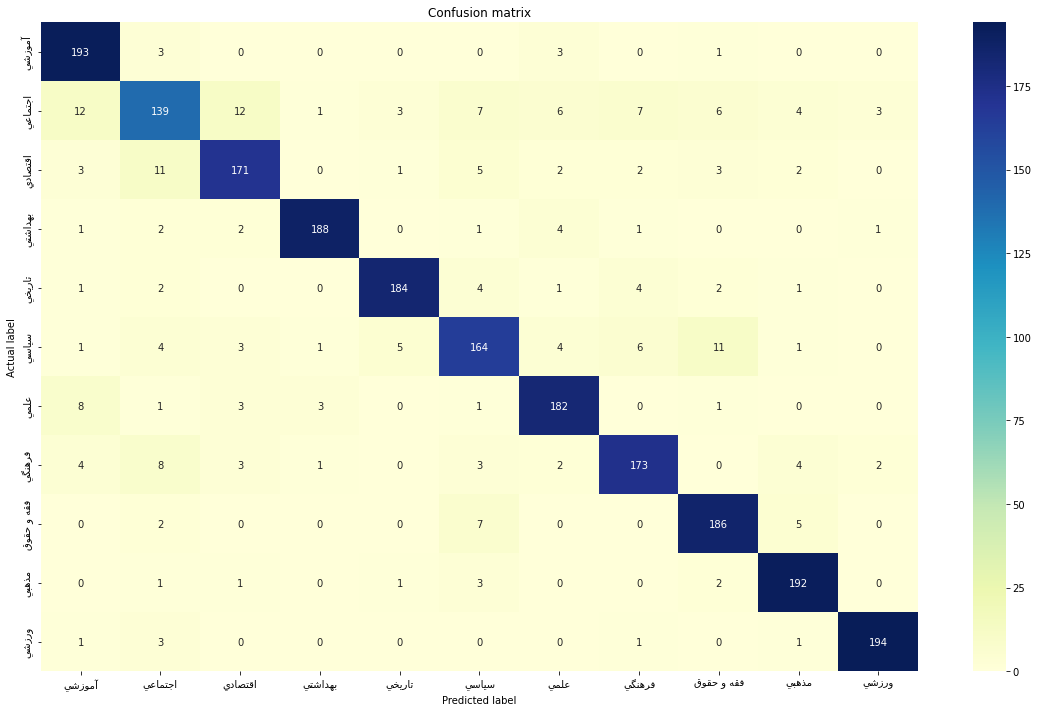

In [33]:
confusion_matrix(y_test, y_preds_test)

In [34]:
classification_report(y_test, y_preds_test)

'              precision    recall  f1-score   support\n\n           0       0.86      0.96      0.91       200\n           1       0.79      0.69      0.74       200\n           2       0.88      0.85      0.87       200\n           3       0.97      0.94      0.95       200\n           4       0.95      0.92      0.94       199\n           5       0.84      0.82      0.83       200\n           6       0.89      0.91      0.90       199\n           7       0.89      0.86      0.88       200\n           8       0.88      0.93      0.90       200\n           9       0.91      0.96      0.94       200\n          10       0.97      0.97      0.97       200\n\n    accuracy                           0.89      2198\n   macro avg       0.89      0.89      0.89      2198\nweighted avg       0.89      0.89      0.89      2198\n'

In [35]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask",
"label"])
# Compute loss values
dataset_encoded["test"] = dataset_encoded["test"].map(
  forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/138 [00:00<?, ?ba/s]

In [36]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(inverse)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(inverse)) 

In [37]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
451,به گزارش گروه دريافت خبر خبرگزاري دانشجويان اي...,علمي,فقه و حقوق,8.344843
2089,ميشل بالاك اخيرا در شهر ژنو سمت نمايندگي ويژه ...,اجتماعي,ورزشي,8.137333
318,در سال ‌٢٠٠٤ همه كشورها ملزم به اجراي مقاوله‌ن...,اقتصادي,فقه و حقوق,7.856896
1625,همچنين مراسم بزرگداشت آيت الله خاتمي بعد از ظه...,اجتماعي,تاريخي,7.683125
66,به گزارش گروه دريافت خبر “ايسنا“، يك مقام مسوو...,اقتصادي,علمي,7.659282
315,به گزارش خبرگزاري دانشجويان ايران (ايسنا)- منط...,اجتماعي,علمي,7.574035
2183,سرپرست فدراسيون وزنه‌برداري گفت:« استان خوزستا...,اجتماعي,ورزشي,7.506331
965,مشاور رييس دولت امارات گفت: سيره‌ي پيامبر (ص) ...,مذهبي,فقه و حقوق,7.461813
439,نتايج آزمون پذيرش بيست وهشتمين دوره‌ي دستياري ...,سياسي,علمي,7.342851
329,در نخستين نمايشگاه بين‌المللي ارتباطات كه با ح...,سياسي,علمي,7.301214


### Test the pipeline with a sample news

In [38]:
from transformers import pipeline

model_id = "/content/drive/MyDrive/NLP/HW5/HooshvareLab/bert-base-parsbert-uncased-finetuned-persika3/checkpoint-2000"
classifier = pipeline("text-classification", model=model_id)

In [39]:
custom_news = "کیمیا علیزاده تکواندوکار آلمانی-ایرانی است. وی نخستین و تنها زن ایرانی است که در تاریخ ورزش ایران در بازی‌های المپیک، برنده مدال شده‌است. با هجده سال سن، جوان‌ترین مدال‌آور تاریخ ایران در دوره‌های المپیک است "
preds = classifier(custom_news, return_all_scores=True)

In [40]:
preds

[[{'label': 'LABEL_0', 'score': 0.0008129160851240158},
  {'label': 'LABEL_1', 'score': 0.001538837910629809},
  {'label': 'LABEL_2', 'score': 0.0009744007838889956},
  {'label': 'LABEL_3', 'score': 0.0006315947393886745},
  {'label': 'LABEL_4', 'score': 0.0006831648643128574},
  {'label': 'LABEL_5', 'score': 0.0013718188274651766},
  {'label': 'LABEL_6', 'score': 0.0018737983191385865},
  {'label': 'LABEL_7', 'score': 0.0016036168672144413},
  {'label': 'LABEL_8', 'score': 0.0004884147783741355},
  {'label': 'LABEL_9', 'score': 0.0010856053559109569},
  {'label': 'LABEL_10', 'score': 0.9889358878135681}]]

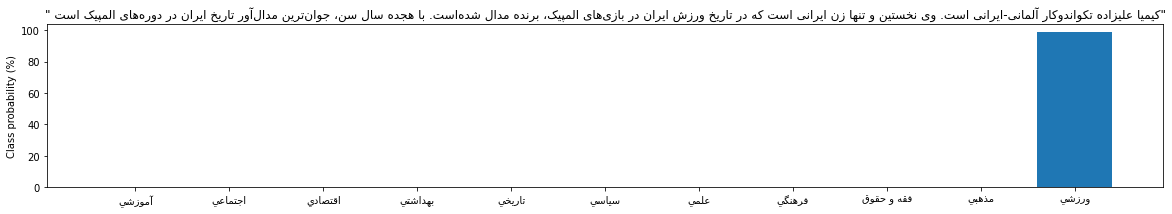

In [42]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

این خبر جزو خبرهای اجتماعی سایت خبرگزاری تنسیم می باشد اما مدل آن را به عنوان خبر آموزشی تشخیص داده است.

In [43]:
custom_news = "آزمون سراسری ۱۴۰۱ با اعلام نتایج اولیه به مراحل پایانی نزدیک می‌شود و امسال هم تقریبا دانش‌آموزان مدارس دولتی از چرخه رقابت برای حضور در میان نفرات برتر کنکور و آزمون‌های علمی حذف شده‌اند و صرفا مدارس غیردولتی یا خاص در این رقابت جای دارند! "
preds = classifier(custom_news, return_all_scores=True)

In [44]:
preds

[[{'label': 'LABEL_0', 'score': 0.6814011335372925},
  {'label': 'LABEL_1', 'score': 0.1072152853012085},
  {'label': 'LABEL_2', 'score': 0.00429080193862319},
  {'label': 'LABEL_3', 'score': 0.00797261018306017},
  {'label': 'LABEL_4', 'score': 0.004660949110984802},
  {'label': 'LABEL_5', 'score': 0.04366200044751167},
  {'label': 'LABEL_6', 'score': 0.11752333492040634},
  {'label': 'LABEL_7', 'score': 0.015100887045264244},
  {'label': 'LABEL_8', 'score': 0.00796626415103674},
  {'label': 'LABEL_9', 'score': 0.0019263721769675612},
  {'label': 'LABEL_10', 'score': 0.008280381560325623}]]

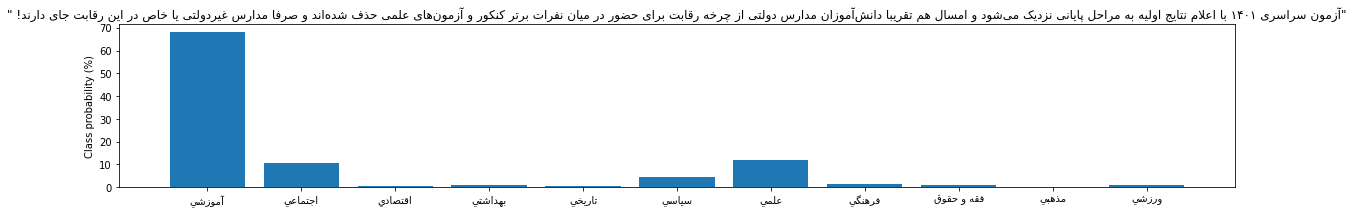

In [46]:
preds_df = pd.DataFrame(preds[0])
plt.bar(classes_fa_style, 100 * preds_df["score"], color='C0')
plt.title(f'"{get_display(reshape(custom_news))}"')
plt.ylabel("Class probability (%)")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

In [ ]:
HooshvareLab/bert-fa-base-uncased-clf-persiannews

## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
# ! pip install optuna
# ! pip install ray[tune]

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2020-10-15 17:06:50,302] A new study created in memory with name: no-name-5ca133fa-884f-4b0b-beb6-82fb19c9da06
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpo

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.567259,0.567516,0.267643
2,0.424672,0.588076,0.360967
3,0.304736,0.882551,0.373388
4,0.172879,1.131409,0.427625


[I 2020-10-15 17:08:54,670] Trial 0 finished with value: 0.4276247641425646 and parameters: {'learning_rate': 9.066394855554376e-05, 'num_train_epochs': 4, 'seed': 3, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.4276247641425646.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.498541,0.470532,0.480649


[I 2020-10-15 17:09:27,505] Trial 1 finished with value: 0.4806486312161432 and parameters: {'learning_rate': 4.70956471834944e-05, 'num_train_epochs': 1, 'seed': 40, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.4806486312161432.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


[I 2020-10-15 17:09:51,733] Trial 2 finished with value: 0.5215162259225145 and parameters: {'learning_rate': 4.357724525964853e-05, 'num_train_epochs': 2, 'seed': 38, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fr

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.526249,0.488950,0.412369
2,0.344729,0.505700,0.505773
3,0.242301,0.565479,0.514625


[I 2020-10-15 17:10:42,034] Trial 3 finished with value: 0.5146251651052666 and parameters: {'learning_rate': 1.966064728684351e-05, 'num_train_epochs': 3, 'seed': 4, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fro

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.619170,0.615369,0.000000


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:00,530] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 1.1681626444738994e-06, 'num_train_epochs': 1, 'seed': 35, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).


Epoch,Training Loss,Validation Loss


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:16,708] Trial 5 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

Epoch,Training Loss,Validation Loss


[I 2020-10-15 17:11:27,293] Trial 6 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_class

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467245,0.477506


[I 2020-10-15 17:11:39,998] Trial 7 finished with value: 0.47750559698251505 and parameters: {'learning_rate': 8.294058232883187e-05, 'num_train_epochs': 1, 'seed': 14, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

Epoch,Training Loss,Validation Loss


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:50,629] Trial 8 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.526511,0.487868,0.449608


[I 2020-10-15 17:12:09,216] Trial 9 finished with value: 0.4496077935780946 and parameters: {'learning_rate': 3.983123210032869e-05, 'num_train_epochs': 1, 'seed': 35, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.


The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
best_run

BestRun(run_id='2', objective=0.5215162259225145, hyperparameters={'learning_rate': 4.357724525964853e-05, 'num_train_epochs': 2, 'seed': 38, 'per_device_train_batch_size': 32})

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


TrainOutput(global_step=536, training_loss=0.4191349371155696)